# Algorithmic Trading Strategy Challenge

Name: Saagar Shah

In this challenge, your task is to design an algorithmic trading strategy using the stocks in the provided portfolio.
    
You may use yfinance to source data for the stocks within the period defined in the dummy_data.xlsx file.

You are not allowed to use a simple "buy and hold" strategy. Be creative and implement a more complex strategy that will maximize profit and minimize risk.

Your solution can be based on machine learning, technical analysis, or any other approach you find suitable.

Be creative and demonstrate your coding ability in this challenge.

In addition to implementing your strategy during this time period, you will also need to graph the profit/loss and liquidity ratio of the strategy over time.

Feel free to add code blocks and markdown blocks as needed, however, ensure specified logic is contained within their respective headers in the notebook.


## Strategy Implementation

# Note
Initially, I created a strategy that used the sentiment ETF "BUZZ" and based on the change in that etf, it would trade. This trade had a return of $25000 over the time period. I decided not to proceed with that strategy as my submission as it only traded once, and it was a fairly simple strategy so I wanted to show more of my coding ability while still using that strategy.I then decided to use the etf strategy along with a couple of metrics to generate buy and sell signals, weighting the metrics differently. The weights were trained using a training period form Jan 1 to Jul 1. Those trained weights were then returned and used in the trading period and backtested.

In [1]:
from Saagar_Shah_portfolio_analysis import PortfolioAnalysis
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random

/Users/saagar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# To find optimal weights
This block of code is used to be able to take in an additional paramater of weight, the weights are randomly generated and the results are stored. This is trained from the beginning of 2023 to the beginning of the trading period

In [2]:
fake_port = PortfolioAnalysis("dummy_data.xlsx")
stocks = list(fake_port.asset_values["Stock"])
stocks.remove('Cash')
stocks.remove('NAV')
totalCash = 200000
weightedAmounts = 200000/len(stocks)
start_date_training = "2023-01-01"
end_date_training = "2023-07-01"
sentiment = yf.download("BUZZ", start=start_date_training, end=end_date_training, progress=False)["Adj Close"].pct_change().fillna(0)


def calculate_vwap_findingWeights(data): #Find VWAP
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    vwap = np.cumsum(typical_price * data['Volume']) / np.cumsum(data['Volume'])
    return pd.Series(vwap, index=data.index)

def buySignals_findingWeights(ticker: str, start_date: str, end_date: str, weight1 : int, weight2: int, weight3 : int): #Generate buy signals
    signals = []
    price_data = yf.download(ticker, start=start_date, end=end_date, progress=False)["Adj Close"]
    window_size = 10 #Sets window size

    # Initialize the moving average and sentiment
    moving_average = np.mean(price_data[:window_size])
    moving_sentiment = np.mean(sentiment[:window_size])
    moving_sd = np.std(price_data[:window_size])
    threshold = moving_sd
    movingAvgWeight = weight1  # Adjusted weight for moving average
    sentimentWeight = weight2  # Adjusted weight for sentiment
    vwapWeight = weight3  # Weight for VWAP

    # Calculate VWAP
    data = yf.download(ticker, start=start_date, end=end_date)
    vwap = calculate_vwap_findingWeights(data)

    for i in range(window_size, len(price_data)): #For each window period
        current_price = price_data[i]

        # Check for mean reversion based on moving average
        if current_price > moving_average + threshold:
            movingAvgResult = -1  # Sell
        elif current_price < moving_average - threshold:
            movingAvgResult = 1  # Buy
        else:
            movingAvgResult = 0  # Hold

        # Check sentiment
        if sentiment[i] > 0:
            sentimentResult = -1
        elif sentiment[i] < 0:
            sentimentResult = 1
        else:
            sentimentResult = 0

        # Check VWAP
        if current_price > vwap.iloc[i]:
            vwapResult = -1  # Sell
        elif current_price < vwap.iloc[i]:
            vwapResult = 1  # Buy
        else:
            vwapResult = 0  # Hold

        # Combine signals using weights
        combined_signal = round(movingAvgWeight * movingAvgResult + sentimentWeight * sentimentResult + vwapWeight * vwapResult)
        signals.append(combined_signal)

        # Update the moving average and threshold
        moving_average = np.mean(price_data[i - window_size + 1: i + 1])
        moving_sd = np.std(price_data[i - window_size + 1: i + 1])
        threshold = moving_sd * 0.5

    return signals #Returns signals


def trade_findingWeights(ticker : str, start_date : str, end_date : str, allocated_amount : float, random_num1 : int, random_num2 : int, random_num3 : int): #Trade using the total allocated amount at a time
    position = 0
    units = 0
    purchasePrice = 0
    pnl = 0
    pnlList = []
    liquid = []
    df = yf.download(ticker, start = start_date, end = end_date, progress=False)["Adj Close"]
    signals = buySignals_findingWeights(ticker, start_date, end_date, random_num1, random_num2, random_num3)
    for i in range(len(signals)):
        listAppend = 0
        if position == 0 and signals[i] == 1: #If no position held and buy signal, buy
            position = 1
            units = allocated_amount/df[i]
            purchasePrice = df[i]
        if position == 1 and signals[i] == -1: #If position is held and sell signal, sell
            position = 0
            listAppend = units * (df[i] - purchasePrice) 
            units = 0
        pnl += listAppend #Store profit/loss
        pnlList.append(listAppend) #Store profit/loss
        liquid.append(abs(position - 1))#Append the liquidity, 1 for liquid and 0 for non liquid
    return pnl

def trade_portfolio_findingWeights(stocks : list, start_date : str, end_date : str): #Trades the portfolio to find the weights
    total_pnl = 0
    total_pnlList = []
    liquidity = pd.DataFrame(columns = stocks)
    random_num2 = random.uniform(0, 1) #Generates Random Weight
    random_num1 = random.uniform(0, 1.49 - random_num2) #Generates second weight
    random_num3 = 1.49 - random_num1 - random_num2 #Generates last weight
    for i in range(len(stocks)):
        curTrade = trade_findingWeights(stocks[i], start_date, end_date, 200000/len(stocks), random_num1, random_num2, random_num3)
        total_pnl += curTrade
    return total_pnl, [random_num1, random_num2, random_num3]

[*********************100%***********************]  1 of 1 completed


This block of code runs the randomized weighted trade, and based on the results with the largest return, uses those weights. (Runtime is very long)

In [4]:
pnlResult = []
weights = []
n = 30
for i in range(n):
    result = trade_portfolio_findingWeights(stocks, "2023-01-01", "2023-07-01")
    pnlResult.append(result[0])
    weights.append(result[1])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
index = pnlResult.index(max(pnlResult))
optimal_Weights = weights[index] #Stores the optimal weights

# Strategy Implementation (With weights found)

In [6]:
fake_port = PortfolioAnalysis("dummy_data.xlsx")
stocks = list(fake_port.asset_values["Stock"])
stocks.remove('Cash')
stocks.remove('NAV')
totalCash = 200000
weightedAmounts = 200000/len(stocks)
sentiment = yf.download("BUZZ", start="2023-07-01", end="2023-09-30", progress=False)["Adj Close"].pct_change().fillna(0)


def calculate_vwap(data): #Calculates Vwap
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    vwap = np.cumsum(typical_price * data['Volume']) / np.cumsum(data['Volume'])
    return pd.Series(vwap, index=data.index)

def buySignals(ticker: str, start_date: str, end_date: str): #Generates buy signals using optimal weights found
    signals = []
    price_data = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]
    window_size = 10

    # Initialize the moving average and sentiment
    moving_average = np.mean(price_data[:window_size])
    moving_sentiment = np.mean(sentiment[:window_size])
    moving_sd = np.std(price_data[:window_size])
    threshold = moving_sd
    movingAvgWeight = optimal_Weights[0]  # Adjusted weight for moving average
    sentimentWeight = optimal_Weights[1]  # Adjusted weight for sentiment
    vwapWeight = optimal_Weights[2]  # Weight for VWAP

    # Calculate VWAP
    data = yf.download(ticker, start=start_date, end=end_date)
    vwap = calculate_vwap(data)

    for i in range(window_size, len(price_data)):
        current_price = price_data[i]

        # Check for mean reversion based on moving average
        if current_price > moving_average + threshold:
            movingAvgResult = -1  # Sell
        elif current_price < moving_average - threshold:
            movingAvgResult = 1  # Buy
        else:
            movingAvgResult = 0  # Hold

        # Check sentiment
        if sentiment[i] > 0:
            sentimentResult = -1
        elif sentiment[i] < 0:
            sentimentResult = 1
        else:
            sentimentResult = 0

        # Check VWAP
        if current_price > vwap.iloc[i]:
            vwapResult = -1  # Sell
        elif current_price < vwap.iloc[i]:
            vwapResult = 1  # Buy
        else:
            vwapResult = 0  # Hold

        # Combine signals using weights
        combined_signal = round(movingAvgWeight * movingAvgResult + sentimentWeight * sentimentResult + vwapWeight * vwapResult)

        signals.append(combined_signal)

        # Update the moving average and threshold
        moving_average = np.mean(price_data[i - window_size + 1: i + 1])
        moving_sd = np.std(price_data[i - window_size + 1: i + 1])
        threshold = moving_sd * 0.5

    return signals


def trade(ticker : str, start_date : str, end_date : str, allocated_amount : float): #Trade using the total allocated amount at a time
    position = 0
    units = 0
    purchasePrice = 0
    pnl = 0
    pnlList = []
    liquid = []
    df = yf.download(ticker, start = start_date, end = end_date, progress=False)["Adj Close"]
    signals = buySignals(ticker, start_date, end_date)
    for i in range(len(signals)):
        listAppend = 0
        if position == 0 and signals[i] == 1:
            position = 1
            units = allocated_amount/df[i]
            purchasePrice = df[i]
        if (position == 1 and signals[i] == -1):
            position = 0
            listAppend = units * (df[i] - purchasePrice)
            units = 0
        pnl += listAppend
        pnlList.append(listAppend)
        liquid.append(abs(position - 1))
    return pnl, liquid, pnlList

def trade_portfolio(stocks : list, start_date : str, end_date : str): #Trades the entire portfolio, storing returns and liquidity
    total_pnl = 0
    total_pnlList = []
    liquidity = pd.DataFrame(columns = stocks)
    for i in range(len(stocks)):
        curTrade = trade(stocks[i], start_date, end_date, 200000/len(stocks))
        total_pnl += curTrade[0]
        liquidity[stocks[i]] = curTrade[1]
        total_pnlList.append(curTrade[2])
    return total_pnl, liquidity, total_pnlList

[*********************100%***********************]  1 of 1 completed


In [7]:
pnl = trade_portfolio(stocks, "2023-07-01", "2023-09-30")[0] #Finds profit and loss
pnl

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

1965.5290390066689

In [8]:
df = yf.download(stocks, start = "2023-07-01", end = "2023-09-30", progress=False)["Adj Close"] #Compares to the market
start = 0
end = 0
for i in stocks:
    start += df[i][0]
for i in stocks:
    end += df[i][len(df[i]) - 1]
marketLoss = (200000/start) * (end - start)
print("Market loss with equally weighted portfolio: $" + str(round(marketLoss, 2)))
print("Algorithmic strategy return: $" + str(round(pnl, 2)))
relativePerformance = (1-pnl/marketLoss) * 100
print("Beat the market by: " + str(round(relativePerformance, 2)) + "%")

Market loss with equally weighted portfolio: $-3778.46
Algorithmic strategy return: $1965.53
Beat the market by: 152.02%


## Plot P/L

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

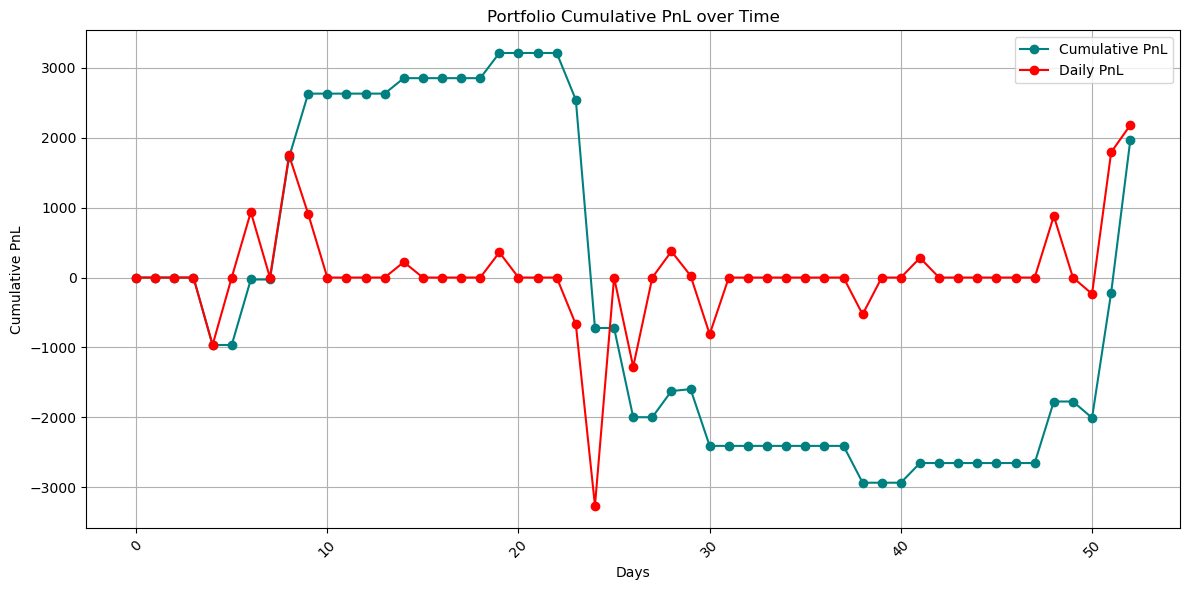

In [9]:
pnls = trade_portfolio(stocks, "2023-07-01", "2023-09-30")[2]
portfolio_pnl = [sum(day_pnls) for day_pnls in zip(*pnls)]
cumulative_pnl = np.cumsum(portfolio_pnl)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_pnl, color='teal', linestyle='-', marker='o', label='Cumulative PnL')
ax.plot(portfolio_pnl, color='red', linestyle='-', marker='o', label='Daily PnL')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative PnL')
ax.set_title('Portfolio Cumulative PnL over Time')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Plot Liquidity

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

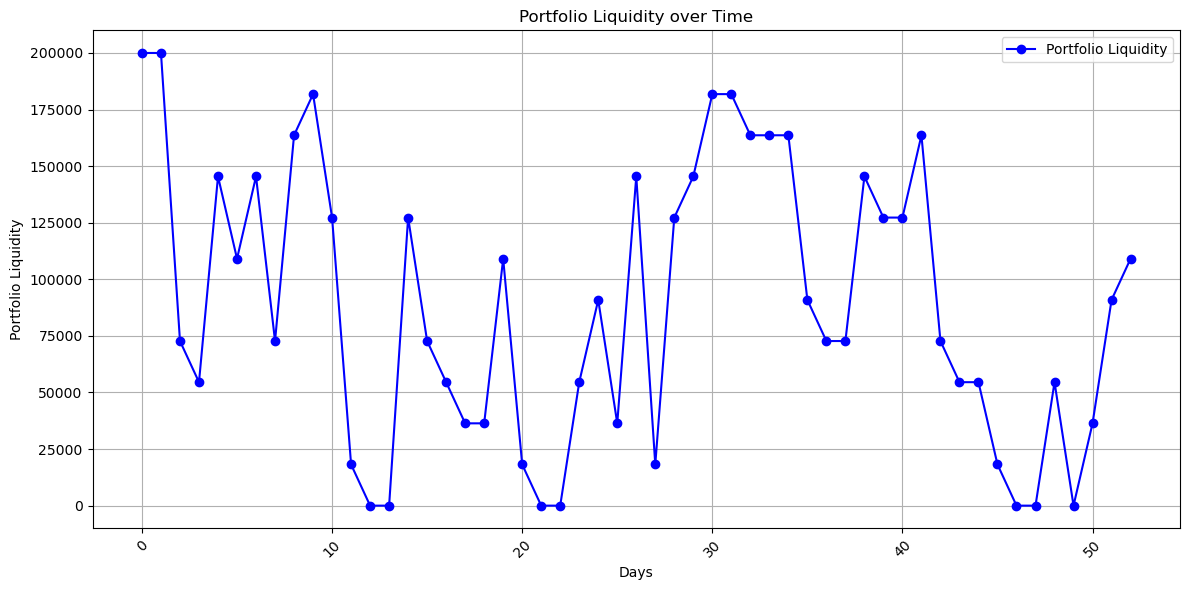

In [10]:
liquidity = trade_portfolio(stocks, "2023-07-01", "2023-09-30")[1]
portfolio_liquidity = liquidity.sum(axis=1) * weightedAmounts
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(portfolio_liquidity, color='blue', linestyle='-', marker='o', label='Portfolio Liquidity')
ax.set_xlabel('Days')
ax.set_ylabel('Portfolio Liquidity')
ax.set_title('Portfolio Liquidity over Time')
ax.tick_params(axis='x', rotation=45)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()